# Training hybrid models using the Pennylane backend

In this example, we will first train a pure quantum model using PennyLane and PyTorch to classify whether a sentence is about cooking or computing. We will then train a hybrid model that takes in pairs of sentences and determines whether they are talking about the same or different topics.

In [1]:
BATCH_SIZE = 10
EPOCHS = 15
SEED = 2

In [2]:
import torch
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

### Read in the data and create diagrams

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

In [ ]:
import os

TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:3], train_data[:3]
    dev_labels, dev_data = dev_labels[:3], dev_data[:3]
    test_labels, test_data = test_labels[:3], test_data[:3]
    EPOCHS = 1

In [4]:
from lambeq import BobcatParser

reader = BobcatParser(verbose='text')

raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Remove cups

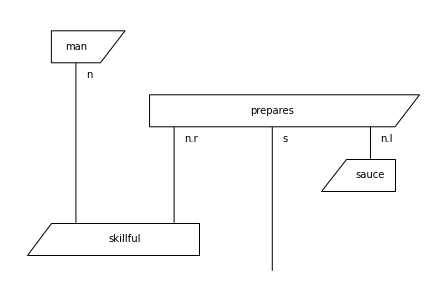

In [5]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

### Create DisCoPy circuits

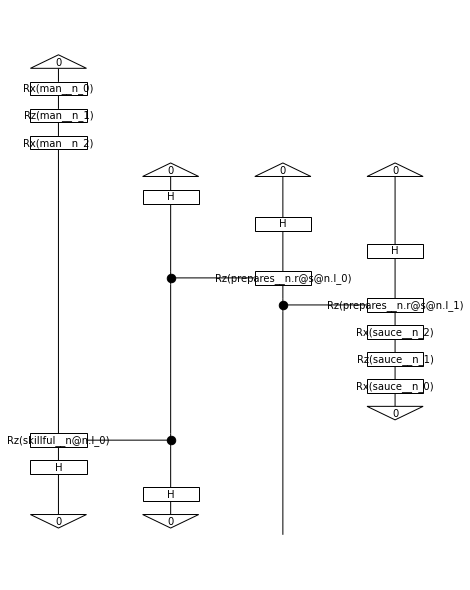

In [6]:
from lambeq import AtomicType, IQPAnsatz

ansatz_cls = IQPAnsatz
ansatz_ob_map = {AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}
ansatz_kwargs = {"n_layers": 1, "n_single_qubit_params": 3}
ansatz = ansatz_cls(
    ansatz_ob_map,
    **ansatz_kwargs,
)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits = [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

all_circuits = train_circuits + dev_circuits + test_circuits

train_circuits[0].draw(figsize=(6, 8))

### Create (pure quantum) model

Parameterisation is now done internally in the `Trainer.fit()` function call. We only need to create a model instance now.

In [7]:
from lambeq import PennyLaneModel

model = PennyLaneModel()

### Prepare train dataset

In [8]:
from lambeq import Dataset

train_dataset = Dataset(train_diagrams,
                        train_labels,
                        batch_size=BATCH_SIZE)

dev_dataset = Dataset(dev_diagrams, dev_labels)
test_dataset = Dataset(test_diagrams, test_labels)

### Training

##### Using `PytorchTrainer`

In [9]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) == 
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

In [10]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        ansatz_cls=ansatz_cls,
        ansatz_ob_map=ansatz_ob_map,
        loss_function=loss,
        optimizer=torch.optim.Adam,
        learning_rate=0.1,
        epochs=EPOCHS,
        ansatz_kwargs=ansatz_kwargs,
        evaluate_functions={"acc": acc},
        evaluate_on_train=True,
        use_tensorboard=False,
        verbose='text',
        seed=SEED
    )

trainer.fit(train_dataset, dev_dataset, test_dataset)

Epoch 1:   train/loss: 0.1778   valid/loss: 0.1430   train/acc: 0.7286   valid/acc: 0.8000
Epoch 2:   train/loss: 0.1054   valid/loss: 0.1081   train/acc: 0.8857   valid/acc: 0.9000
Epoch 3:   train/loss: 0.0716   valid/loss: 0.0658   train/acc: 0.9286   valid/acc: 0.9000
Epoch 4:   train/loss: 0.0618   valid/loss: 0.0262   train/acc: 0.9429   valid/acc: 0.9667
Epoch 5:   train/loss: 0.0427   valid/loss: 0.0468   train/acc: 0.9714   valid/acc: 0.9333
Epoch 6:   train/loss: 0.0159   valid/loss: 0.0261   train/acc: 0.9714   valid/acc: 0.9667
Epoch 7:   train/loss: 0.0212   valid/loss: 0.0130   train/acc: 0.9857   valid/acc: 1.0000
Epoch 8:   train/loss: 0.0192   valid/loss: 0.0246   train/acc: 0.9714   valid/acc: 1.0000
Epoch 9:   train/loss: 0.0804   valid/loss: 0.1782   train/acc: 0.9143   valid/acc: 0.6667
Epoch 10:  train/loss: 0.0386   valid/loss: 0.1091   train/acc: 0.9286   valid/acc: 0.8667
Epoch 11:  train/loss: 0.0384   valid/loss: 0.0877   train/acc: 0.9571   valid/acc: 0.8667

##### Determine test accuracy

In [11]:
def accuracy(circs, labels):
    probs = model(circs)
    return (torch.argmax(probs, dim=1) == 
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

accuracy(test_circuits, test_labels)

0.9

##### Using standard PyTorch

As we have a small dataset, we can use early stopping to prevent overfitting to the training data.

In [12]:
def accuracy(circs, labels):
    probs = model(circs)
    return (torch.argmax(probs, dim=1) == 
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

In [13]:
import pickle

model = PennyLaneModel.from_diagrams(all_circuits)
model.initialise_weights()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for diagrams, labels in train_dataset:
        optimizer.zero_grad()
        circuits = [ansatz(diagram) for diagram in diagrams]
        probs = model(circuits)
        d_type = model.weights[0].dtype
        probs = probs.to(d_type)
        loss = torch.nn.functional.mse_loss(probs, 
                                            torch.tensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    if i % 5 == 0:
        dev_acc = accuracy(dev_circuits, dev_labels)
        
        print("Epoch: {}".format(i))
        print("Train loss: {}".format(epoch_loss))
        print("Dev acc: {}".format(dev_acc))
        
        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            checkpoint = model._make_checkpoint()
            with open("model.lt", "wb+") as f:
                pickle.dump(checkpoint, f)
        elif i - best['epoch'] >= 10:
            print("Early stopping")
            with open("model.lt", "rb") as f:
                checkpoint = pickle.load(f)
            model = PennyLaneModel._load_checkpoint(checkpoint)
            break
    

Epoch: 0
Train loss: 1.61824881285429
Dev acc: 0.6333333333333333
Epoch: 5
Train loss: 0.4483018293976784
Dev acc: 0.8666666666666667
Epoch: 10
Train loss: 0.07727803220041096
Dev acc: 0.9333333333333333


### Determine the test accuracy

In [14]:
accuracy(test_circuits, test_labels)

0.9666666666666667

### Creating a hybrid model

This model will take in pairs of diagrams and attempt to determine whether they are talking about the same or different topics. It does this by first running the circuits to get a probability ouput on the open wire, and then passes this output to a simple neural network. We expect the circuits to learn to output [0, 1] or [1, 0] depending on the topic they are referring to (cooking or computing), and the neural network to learn to XOR these outputs to determine whether the topics are the same (in which case it should ouput 0) or different (in which case it should output 1). PennyLane allows us to train both the circuits and the NN simultaneously using PyTorch autograd.

In [15]:
BATCH_SIZE = 50
EPOCHS = 100
SEED = 2

As the probability outputs from our circuits are guaranteed to be positive, we transform these outputs `x` by `2 * (x - 0.5)`, giving inputs to the neural network in the range [-1, 1]. This helps us to avoid "dying ReLUs", which could otherwise occur if all the input weights to a given neuron were negative, leading to the gradient of all these weights being 0. (A couple of alternative approaches could also involve initialising all the neural network weights to be positive, or using `LeakyReLU` as the activation function).

In [16]:
from torch import nn

class XORSentenceModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)
        
        self.xor_net = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
            )
        
    def forward(self, diagram_pairs):
        a, b = zip(*diagram_pairs)
        evaluated_pairs = torch.cat((self.get_diagram_output(a),
                                     self.get_diagram_output(b)),
                                    dim=1)
        evaluated_pairs = 2 * (evaluated_pairs - 0.5)
        out = self.xor_net(evaluated_pairs)
        return out
        

### Make paired dataset

In [17]:
from itertools import combinations

def make_pair_data(diagrams, labels):
    pair_diags = list(combinations(diagrams, 2))
    pair_labels = [int(x[0] == y[0]) for x, y in combinations(labels, 2)]
    
    return pair_diags, pair_labels

train_pair_circuits, train_pair_labels = make_pair_data(train_circuits, 
                                                        train_labels)
dev_pair_circuits, dev_pair_labels = make_pair_data(dev_circuits, dev_labels)
test_pair_circuits, test_pair_labels = make_pair_data(test_circuits, 
                                                      test_labels)

There are lots of pairs (2415 train pairs), so we'll sample a subset to make this example train more quickly.

In [18]:
TRAIN_SAMPLES, DEV_SAMPLES, TEST_SAMPLES = 300, 200, 200

In [18]:
if TESTING:
    TRAIN_SAMPLES, DEV_SAMPLES, TEST_SAMPLES = 2, 2, 2

In [19]:
train_pair_circuits, train_pair_labels = (
    zip(*random.sample(list(zip(train_pair_circuits, train_pair_labels)),
                       TRAIN_SAMPLES)))
dev_pair_circuits, dev_pair_labels = (
    zip(*random.sample(list(zip(dev_pair_circuits, dev_pair_labels)), DEV_SAMPLES)))
test_pair_circuits, test_pair_labels = (
    zip(*random.sample(list(zip(test_pair_circuits, test_pair_labels)), TEST_SAMPLES)))

### Initialise the model

In [20]:
all_pair_circuits = (train_pair_circuits +
                     dev_pair_circuits +
                     test_pair_circuits)
a, b = zip(*all_pair_circuits)

model = XORSentenceModel.from_diagrams(a + b)
model.initialise_weights()
model = model.double()

train_pair_dataset = Dataset(train_pair_circuits,
                             train_pair_labels,
                             batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

### Train the model and log accuracies

Only log every five epochs as evaluating is expensive.

In [21]:
def accuracy(circs, labels):
    predicted = model(circs)
    return (torch.round(torch.flatten(predicted)) == 
            torch.DoubleTensor(labels)).sum().item()/len(circs)

In [22]:
best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_pair_dataset:
        optimizer.zero_grad()
        predicted = model(circuits)
        loss = torch.nn.functional.binary_cross_entropy(
            torch.flatten(predicted), torch.DoubleTensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    if i % 5 == 0:
        dev_acc = accuracy(dev_pair_circuits, dev_pair_labels)
        
        print("Epoch: {}".format(i))
        print("Train loss: {}".format(epoch_loss))
        print("Dev acc: {}".format(dev_acc))
        
        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.save("xor_model.lt")
        elif i - best['epoch'] >= 10:
            print("Early stopping")
            model.load("xor_model.lt")
            model = model.double()
            break

Epoch: 0
Train loss: 4.202134637529463
Dev acc: 0.445
Epoch: 5
Train loss: 4.152931421145276
Dev acc: 0.54
Epoch: 10
Train loss: 3.9137668866046615
Dev acc: 0.62
Epoch: 15
Train loss: 3.4010897127113733
Dev acc: 0.655
Epoch: 20
Train loss: 2.41645528073079
Dev acc: 0.825
Epoch: 25
Train loss: 2.5319179155031915
Dev acc: 0.885
Epoch: 30
Train loss: 0.2144302081166329
Dev acc: 0.995
Epoch: 35
Train loss: 0.07569202568470873
Dev acc: 1.0
Epoch: 40
Train loss: 0.04757411482113485
Dev acc: 1.0
Epoch: 45
Train loss: 0.033591968613830424
Dev acc: 1.0
Early stopping


In [23]:
accuracy(test_pair_circuits, test_pair_labels)

1.0